<a href="https://colab.research.google.com/github/Youngpyoryu/Mixture-Density-Model/blob/main/Mixture_density_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mixture Density Networks


A mixture density network (MDN) is an interesting model formalism built within the general framework of neural networks and probability theory for working on supervised learning problems in which the target variable cannot be easily approximated by a single standard probability distribution. 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

# Reload an IPython extension by its module name.
%load_ext autoreload 
%autoreload 2
# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# One to Many function

In [23]:
n_samples = 1000

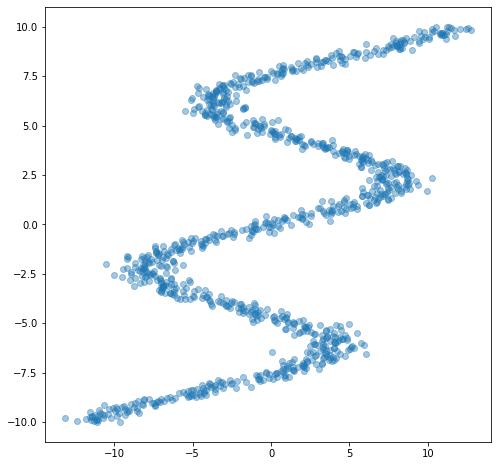

In [24]:
epsilon = torch.randn(n_samples)
x_data = torch.linspace(-10, 10, n_samples)
y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon

y_data, x_data = x_data.view(-1, 1), y_data.view(-1, 1)

plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.4)
plt.show()

In [25]:
n_input = 1
n_hidden = 20
n_output = 1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

loss_fn = nn.MSELoss()

optimizer = torch.optim.RMSprop(model.parameters())

In [26]:
for epoch in range(3000):
    y_pred = model(x_data) 
    loss = loss_fn(y_pred, y_data) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if epoch % 1000 == 0:
        print(loss.data.tolist())

32.32730484008789
22.12604522705078
22.080766677856445


In [27]:
x_test = torch.linspace(-15, 15, n_samples).view(-1, 1)
y_pred = model(x_test).data

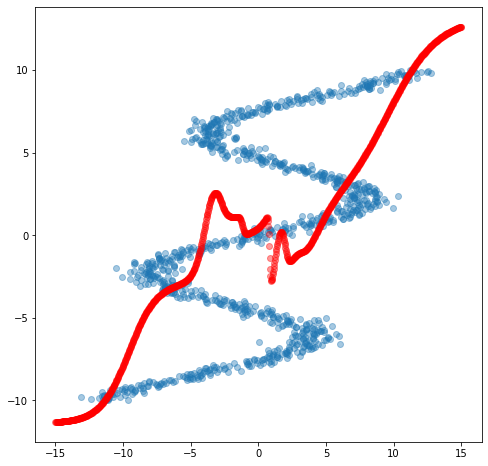

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.4)
plt.scatter(x_test, y_pred, alpha=0.4, color='red')
plt.show()

## Mixture Density Networks

In [29]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

model = MDN(n_hidden=20, n_gaussians=5)

optimizer = torch.optim.Adam(model.parameters())

In [30]:
def mdn_loss_fn(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

In [31]:
for epoch in range(10000):
    pi, mu, sigma = model(x_data)
    loss = mdn_loss_fn(y_data, mu, sigma, pi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(loss.data.tolist())

7.619635581970215
2.8691041469573975
2.215332269668579
1.5381758213043213
1.455796718597412
1.4136563539505005
1.3803215026855469
1.35947585105896
1.3500880002975464
1.3317488431930542


In [32]:
pi, mu, sigma = model(x_test)

In [33]:
k = torch.multinomial(pi, 1).view(-1)
y_pred = torch.normal(mu, sigma)[np.arange(n_samples), k].data

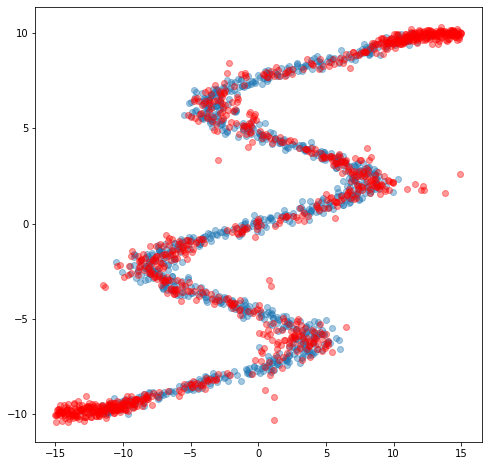

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.4)
plt.scatter(x_test, y_pred, alpha=0.4, color='red')
plt.show()

### Another Example


In [35]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

plt.rcParams['figure.figsize'] = (8, 8)
np.random.seed(42)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate data

To begin with, let's generate a training dataset that matches that from PRML, p. 272. Specifically, let's generate a matrix $\mathbf{X}$ of $n$ observations of a 1-dimensional variable $\mathbf{x}$ by sampling uniformly over the interval $[0, 1)$, and then generate a corresponding matrix $\mathbf{Y}$ of $n$ target observations of a 1-dimensional variable $\mathbf{y}$ by computing

$$\mathbf{Y} = \mathbf{X} + 0.3\sin(2\pi \mathbf{X}) + \mathbf{noise}\text{,}$$
where $\mathbf{noise}$ is a vector of $n$ uniform values sampled over the interval $[-0.1, 0.1)$.

In [36]:
# generate data
n = 2500
d = 1
t = 1
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
y_train = x_train + 0.3*np.sin(2*np.pi*x_train) + noise
x_test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)

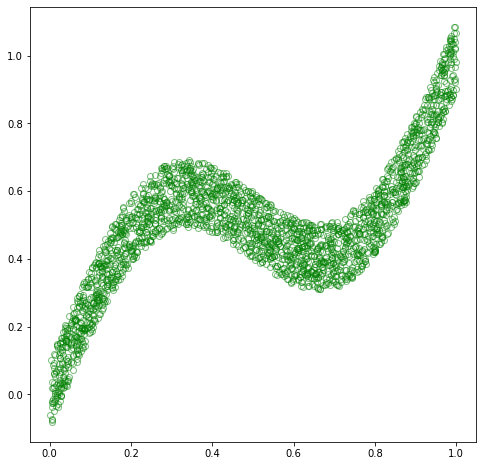

In [37]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

###Train a model

Now, let's train a model to learn the process that generated this dataset, i.e., the mapping from $\mathbf{x}$ to $\mathbf{y}$, or the conditional distribution $p(\mathbf{y}|\mathbf{x})$. For this dataset, $p(\mathbf{y}|\mathbf{x})$ is unimodal, i.e., there appears to be a single distribution over $\mathbf{y}$ for each observation of $\mathbf{x}$. Thus, we could assume a Gaussian distribution for $p(\mathbf{y}|\mathbf{x})$, and treat this problem as a standard regression problem. Therefore, we need to construct a model that accepts an example $\mathbf{x}_i$ and produces a value $\mathbf{out}_i$, which we can interpret as the mean parameter of a Gaussian distribution for $\mathbf{y}_i$. We can then construct a loss function as the negative log likelihood assuming a Gaussian distribution, and optimize this loss w.r.t. the parameters of our model. In terms of the actual model, we can make use of a neural network as a general framework for function approximation, and construct a simple, two-layer, non-linear neural net with a sufficient number of parameters to be able to fit the given dataset.

In [38]:
# define a simple neural net
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the data as Variables
x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

# select an optimizer
# NOTE: there are a few options here -- feel free to explore!
# opt = optim.SGD([w1, b1, w2, b2], lr=0.1)
opt = optim.SGD([w1, b1, w2, b2], lr=0.09, momentum=0.9, nesterov=True)
# opt = optim.RMSprop([w1, b1, w2, b2], lr=0.002, alpha=0.999)
# opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
# 10000 for SGD, 2000 for SGD w/ nesterov momentum, 4000 for RMSprop, 800 for Adam
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data)
  loss.backward()
  opt.step()

0 tensor(0.1319)
100 tensor(0.0212)
200 tensor(0.0207)
300 tensor(0.0200)
400 tensor(0.0188)
500 tensor(0.0170)
600 tensor(0.0142)
700 tensor(0.0103)
800 tensor(0.0065)
900 tensor(0.0048)
1000 tensor(0.0043)
1100 tensor(0.0047)
1200 tensor(0.0043)
1300 tensor(0.0040)
1400 tensor(0.0039)
1500 tensor(0.0037)
1600 tensor(0.0036)
1700 tensor(0.0036)
1800 tensor(0.0035)
1900 tensor(0.0035)


Now, let's make predictions and plot the values against the original dataset to see how well we are able to approximate the training dataset.

In [39]:
# predict
out = forward(Variable(torch.from_numpy(x_test)))

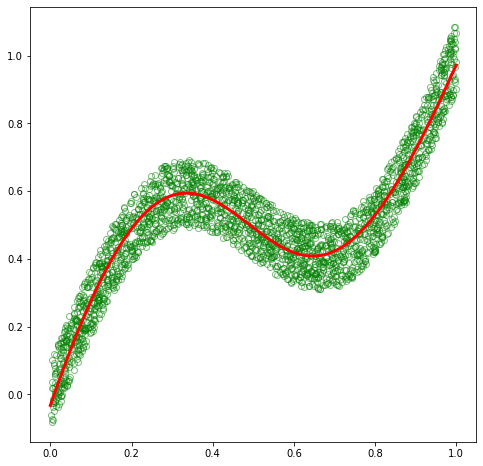

In [40]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth=3.0)
plt.show()

Inverse problem
To motivate the usefulness of MDNs, let's invert the problem by swapping $\mathbf{X}$ and $\mathbf{Y}$ as

$$\mathbf{X} = \mathbf{Y} + 0.3\sin(2\pi \mathbf{Y}) + \mathbf{noise}\text{,}$$
and then solve for $\mathbf{Y}$.

In [41]:
x_train_inv = y_train
y_train_inv = x_train
x_test = np.linspace(-0.1, 1.1, n).reshape(-1, 1).astype(np.float32)  # new x has a slightly different range

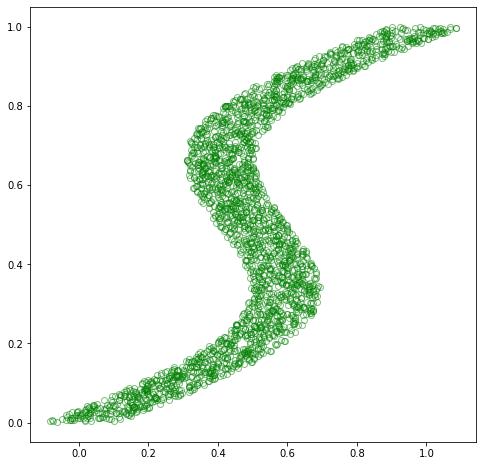

In [42]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.show()

Let's make use of the same model structure, fit this new dataset, and then get out of here.

In [43]:
# define a simple neural net
h = 15
w1 = Variable(torch.randn(d, h) * np.sqrt(1/d), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w2 = Variable(torch.randn(h, t) * np.sqrt(1/h), requires_grad=True)
b2 = Variable(torch.zeros(1, t), requires_grad=True)

def forward(x):
  out = torch.tanh(x.mm(w1) + b1)  # a relu introduces kinks in the predicted curve
  out = out.mm(w2) + b2
  return out

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

# select an optimizer
# opt = optim.SGD([w1, b1, w2, b2], lr=0.1)
# opt = optim.SGD([w1, b1, w2, b2], lr=0.09, momentum=0.9, nesterov=True)
# opt = optim.RMSprop([w1, b1, w2, b2], lr=0.002, alpha=0.999)
opt = optim.Adam([w1, b1, w2, b2], lr=0.09)

# optimize
for e in range(2000):
  opt.zero_grad()
  out = forward(x)
  loss = F.mse_loss(out, y)  # negative log likelihood assuming a Gaussian distribution
  if e % 100 == 0:
    print(e, loss.data)
  loss.backward()
  opt.step()

0 tensor(0.3316)
100 tensor(0.0474)
200 tensor(0.0473)
300 tensor(0.0473)
400 tensor(0.0472)
500 tensor(0.0467)
600 tensor(0.0450)
700 tensor(0.0439)
800 tensor(0.0422)
900 tensor(0.0406)
1000 tensor(0.0403)
1100 tensor(0.0400)
1200 tensor(0.0400)
1300 tensor(0.0399)
1400 tensor(0.0401)
1500 tensor(0.0399)
1600 tensor(0.0399)
1700 tensor(0.0400)
1800 tensor(0.0399)
1900 tensor(0.0398)


In [44]:
# predict
out = forward(Variable(torch.from_numpy(x_test)))

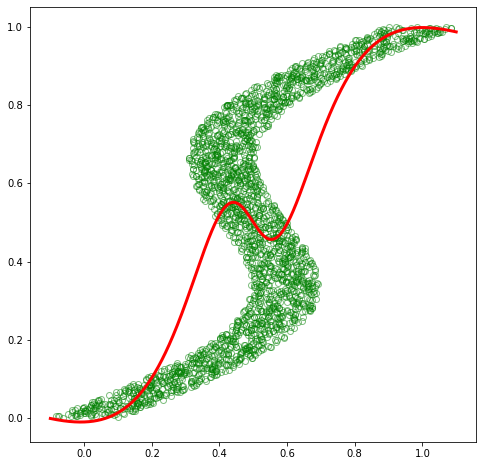

In [45]:
# plot
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, out.data.numpy(), 'r', linewidth=3.0)
plt.show()

Unfortunately, our model was not able to fit this inverse dataset at all. If we think about it a bit, we can see that this is a hard problem for a regular model with a single output to effectively fit. In the original dataset, although there was some amount of noise, there appeared to be a single, distinct distribution of $\mathbf{y}$ for each observation of $\mathbf{x}$, and thus a Gaussian distribution parameterized by a function of $\mathbf{x}$ was able to approximate $p(\mathbf{y}|\mathbf{x})$ quite well. However, in this inverse dataset, there appear to be multiple distinct distributions of $\mathbf{y}$ for many of the $\mathbf{x}$ observations, and thus a single Gaussian distribution is not able to approximate this multimodal conditional distribution.

What if our model could parameterize a mixture of Gaussian distributions to approximate $p(\mathbf{y}|\mathbf{x})$? Bingo – this is exactly the goal of a MDN. Let's try it!

### Mixture density networks
As mentioned at the beginning of our exploration, an MDN is a flexible framework for modeling an arbitrary conditional probability distribution $p(\mathbf{y}|\mathbf{x})$ as a mixture of distributions, parameterized by functions of the input $\mathbf{x}$. More specifically, we can construct an MDN by creating a neural network to parameterize a mixture model consisting of some predefined types of distributions. For this dataset, we'll continue to make use of Gaussian distributions, and thus our neural net will parameterize a Gaussian mixture model (GMM), which is effectively a normalized linear combination of $K$ Gaussian distributions. Formally, we can express the conditional probability $p(\mathbf{y}|\mathbf{x})$ as

$$
p(\mathbf{y}|\mathbf{x}) = \sum_k \pi_k(\mathbf{x}) N(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x})) \text{,}
$$
where $\boldsymbol{\pi}(\mathbf{x})$ is a normalized vector of $k$ mixing coefficients as a function of $\mathbf{x}$, and $N(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), I\sigma_k^2(\mathbf{x}))$ is a Gaussian component density with means $\boldsymbol{\mu}_k(\mathbf{x})$ and variance $\sigma_k^2(\mathbf{x})$, both of which are also functions of $\mathbf{x}$. Note that although we use per-dimensional means, we simplify the covariance matrix to be isotropic, i.e., equal variances for each dimension of $\mathbf{x}$ (see PRML, p. 273). Also note that the mixing coefficients, means, and variances are all functions of the inputs $\mathbf{x}$, and as such, represent the outputs of our neural net.

Let's unpack this a bit. Essentially, we decided that our original approach of approximating $p(\mathbf{y}|\mathbf{x})$ with a single Gaussian distribution was insufficient, and that making use of multiple Gaussians could be more effective. Thus, we constructed a framework in which, for a given observation of $\mathbf{x}$, our model outputs the parameters for $K$ Gaussian distributions, as well as $K$ coefficients summing to one that indicate the relative amounts by which to combine the distributions. Then, for some new observation of $\mathbf{x}$, we could generate the parameters of this mixture model to form a complex distribution of $\mathbf{y}$, from which we could draw samples in various ways to generate probable predictions of $\mathbf{y}$.

In [46]:
# dimensionality of hidden layer
h = 50
# K mixing components (PRML p. 274)
# Can also formulate as a K-dimensional, one-hot
# encoded, latent variable $z$, and have the model
# produce values for $\mu_k = p(z_k = 1)$, i.e., the
# prob of each possible state of $z$. (PRML p. 430)
k = 30  # 3
# We specialize to the case of isotropic covariances (PRML p. 273),
# so the covariance matrix is diagonal with equal diagonal elements,
# i.e., the variances for each dimension of y are equivalent.
# therefore, the MDN outputs pi & sigma scalars for each mixture
# component, and a mu vector for each mixture component containing
# means for each target variable.
# NOTE: we could use the shorthand `d_out = 3*k`, since our target
# variable for this project only has a dimensionality of 1, but
# the following is more general.
# d_out = (t + 2) * k  # t is L from PRML p. 274
# NOTE: actually cleaner to just separate pi, sigma^2, & mu into
# separate functions.
d_pi = k
d_sigmasq = k
d_mu = t * k

w1 = Variable(torch.randn(d, h) * np.sqrt(2/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)
def forward(x):
  out = F.tanh(x.mm(w1) + b1)  # shape (n, h)
  #out = F.leaky_relu(x.mm(w1) + b1)  # interesting possibility
  pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)  # p(z_k = 1) for all k; K mixing components that sum to 1; shape (n, k)
  sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)  # K gaussian variances, which must be >= 0; shape (n, k)
  mu = out.mm(w_mu) + b_mu  # K * L gaussian means; shape (n, k*t)
  return pi, sigmasq, mu
  

def gaussian_pdf(x, mu, sigmasq):
  # NOTE: we could use the new `torch.distributions` package for this now
  return (1/torch.sqrt(2*np.pi*sigmasq)) * torch.exp((-1/(2*sigmasq)) * torch.norm((x-mu), 2, 1)**2)   


def loss_fn(pi, sigmasq, mu, target):
  # PRML eq. 5.153, p. 275  
  # compute the likelihood p(y|x) by marginalizing p(z)p(y|x,z)
  # over z. for now, we assume the prior p(w) is equal to 1,
  # although we could also include it here.  to implement this,
  # we average over all examples of the negative log of the sum
  # over all K mixtures of p(z)p(y|x,z), assuming Gaussian
  # distributions.  here, p(z) is the prior over z, and p(y|x,z)
  # is the likelihood conditioned on z and x.
  losses = Variable(torch.zeros(n))  # p(y|x)
  for i in range(k):  # marginalize over z
    likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
    prior_z = pi[:, i]
    losses += prior_z * likelihood_z_x
  loss = torch.mean(-torch.log(losses))
  return loss

In [47]:
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.008)

# wrap up the inverse data as Variables
x = Variable(torch.from_numpy(x_train_inv))
y = Variable(torch.from_numpy(y_train_inv))

for e in range(3000):
  opt.zero_grad()
  pi, sigmasq, mu = forward(x)
  loss = loss_fn(pi, sigmasq, mu, y)
  if e % 100 == 0:
    print(loss.data)
  loss.backward()
  opt.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(1.1151)
tensor(-0.6334)
tensor(-0.9605)
tensor(-1.0188)
tensor(-1.0501)
tensor(-1.0582)
tensor(-1.0644)
tensor(-1.0707)
tensor(-1.0862)
tensor(-1.0910)
tensor(-1.0944)
tensor(-1.0989)
tensor(-1.1016)
tensor(-1.0404)
tensor(-1.1028)
tensor(-1.0959)
tensor(-1.1058)
tensor(-1.1011)
tensor(-1.0218)
tensor(-1.1092)
tensor(-1.0955)
tensor(-1.1116)
tensor(-1.1009)
tensor(-0.6530)
tensor(-1.1140)
tensor(-1.0569)
tensor(-1.1155)
tensor(-1.0915)
tensor(-1.1066)
tensor(-1.1172)


Now, let's sample from the model. We have a few options here, of which we'll explore two. Specifically, we can either sample the mean $\mathbf{\mu}_k(\mathbf{x})$ for the most probable Gaussian component, or we can sample several points from the conditional distribution $p(\mathbf{y}|\mathbf{x},\mathbf{w})$ for each observation of $\mathbf{x}$, and plot them all together.

In [48]:
def sample_mode(pi, sigmasq, mu):
  # for prediction, could use conditional mode, but it doesn't
  # have an analytical solution (PRML p. 277). alternative is
  # to return the mean vector of the most probable component,
  # which is the approximate conditional mode from the mixture
  # NOTE: this breaks autograd, but that's fine because we
  # won't be computing gradients for this path
  # NOTE: pi, sigmasq, & mu are tensors
  n, k = pi.shape
  _, kt = mu.shape
  t = int(kt / k)
  _, max_component = torch.max(pi, 1)  # mixture w/ largest prob, i.e., argmax_k p(z==1)
  out = Variable(torch.zeros(n, t))
  for i in range(n):
    for j in range(t):
      out[i, j] = mu[i, max_component.data[i]*t+j]
  return out


def sample_preds(pi, sigmasq, mu, samples=10):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

In [49]:

# sample
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
preds = sample_preds(pi, sigmasq, mu, samples=10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


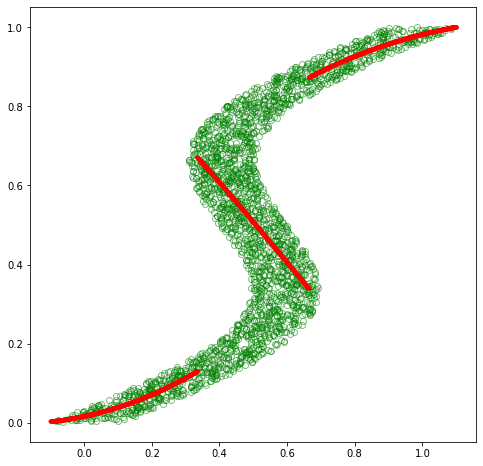

In [50]:
# plot the conditional mode at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, cond_mode.data.numpy(), 'r.')
plt.show()

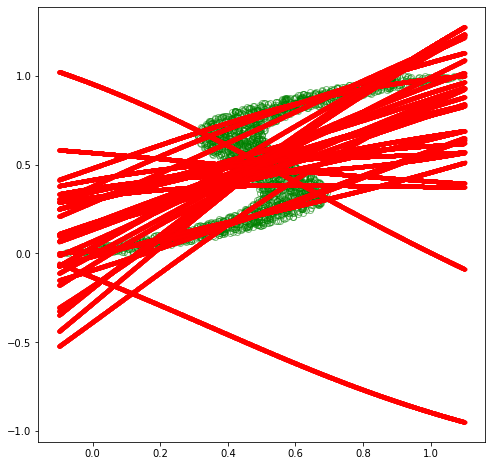

In [51]:
# plot the means at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, mu.data.numpy(), 'r.')
plt.show()

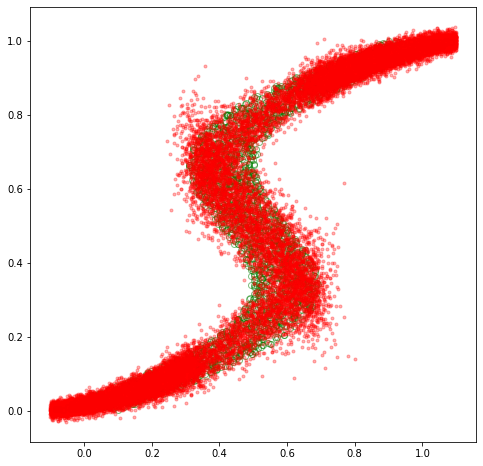

In [52]:
# plot sampled predictions at each point along x
fig = plt.figure(figsize=(8,8))
plt.plot(x_train_inv, y_train_inv, 'go', alpha=0.5, markerfacecolor='none')
for i in range(preds.shape[1]):
  plt.plot(x_test, preds.data.numpy()[:, i].reshape(n, 1), 'r.', alpha=0.3)
plt.show()

Fascinating! Our MDN model appears to have learned to approximate $p(\mathbf{y}|\mathbf{x})$ for this inverse dataset decently well! We could go back and experiment with different hyperparameter values, such as different values for $K$, which would yield varying levels of fits. Specifically, the mean plot becomes more intelligible with lower values of $K$, such as $K=3$, while higher values will lead to better fits.

Final thoughts
Overall, we've explored an interesting "inverse" scenario in which the distribution of our continuous target variable $\mathbf{y}$ exhibits multimodality that is not well approximated by a single Gaussian distribution, and have explored mixture density networks as a general framework for such scenarios. Hopefully the derivations and implementations here, as well as the great PRML textbook, can serve as useful resources for further exploration of the topic.